In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from ortools.linear_solver.pywraplp import Solver
from numba import njit
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("F:/BI/第十二周/L22/santa/family_data.csv", index_col='family_id')
df.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [4]:
df.describe()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000
mean,40.715000,41.601000,41.194200,41.595000,41.950600,42.63520,41.965000,42.739600,42.33900,42.608200,4.20060
std,29.054208,29.518375,28.821878,29.094602,29.045049,28.98729,28.711089,28.959156,28.69832,28.116088,1.53272
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,2.00000
25%,16.000000,16.000000,17.000000,17.000000,17.000000,18.00000,17.000000,18.000000,17.00000,19.000000,3.00000
50%,38.000000,38.000000,38.000000,39.000000,39.000000,40.00000,39.000000,39.000000,39.00000,39.000000,4.00000
75%,62.000000,66.000000,63.000000,66.000000,66.000000,66.00000,66.000000,67.000000,66.00000,66.000000,5.00000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,8.00000


In [5]:
# 总人数
df['n_people'].sum()

21003

In [6]:
# 数据预处理
def get_p_cost(i: int, n_people: int) -> int:
    """计算p_cost的损失
    :param i: choice_i
    :param n_people: 家庭成员数
    """
    p_cost = 0
    # 不同choice的折扣卡
    gift_cards = [0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500]
    # 每个家庭成员不同choice的优惠折扣
    discount_everyone = [0, 0, 9, 9, 9, 18, 18, 36, 36, 235, 434]

    if i >= 0 and i <= 9:
        # choice i 的pcost
        p_cost = gift_cards[i] + discount_everyone[i] * n_people
    else:
        p_cost = gift_cards[-1] + discount_everyone[-1] * n_people
    return p_cost

In [7]:
N_FAMILY = 5000  # 家庭数量
N_DAYS = 100  # 每天访问的人数需要在125-300人
MIN_OCCUPANCY = 125  # 最小承载量
MAX_OCCUPANCY = 300  # 最大承载量

In [8]:
pcost_mat = np.full(shape=(N_FAMILY, N_DAYS), fill_value=99999)

for r in range(N_FAMILY):
    n_people = df.loc[r, 'n_people']
    # 初始化
    pcost_mat[r, :] = get_p_cost(9, n_people)
    for i in range(10):
        col = "choice_%d" % i
        day = df.loc[r, col]
        pcost_mat[r, day - 1] = get_p_cost(i, n_people)
print("计算完毕")
pcost_mat

计算完毕


array([[1440, 1440, 1440, ..., 1440, 1440, 1440],
       [1440, 1440, 1440, ..., 1440, 1440, 1440],
       [1205, 1205, 1205, ..., 1205, 1205,    0],
       ...,
       [1910, 1910,  616, ..., 1910, 1910, 1910],
       [ 390, 1675, 1675, ..., 1675, 1675, 1675],
       [1440, 1440, 1440, ..., 1440, 1440, 1440]])

In [11]:
pcost_mat[0, 51]  # 第0个家庭，choice_0 为 day 52 的成本

0

In [12]:
# # 计算pcost_mat第二种方法
# def get_penalty(choice, n):
#     if choice == 0:
#         penalty = 0
#     if choice == 1:
#         penalty = 50
#     if choice == 2:
#         penalty = 50 + 9 * n
#     if choice == 3:
#         penalty = 100 + 9 * n
#     if choice == 4:
#         penalty = 200 + 9 * n
#     if choice == 5:
#         penalty = 200 + 18 * n
#     if choice == 6:
#         penalty = 300 + 18 * n
#     if choice == 7:
#         penalty = 300 + 36 * n
#     if choice == 8:
#         penalty = 400 + 36 * n
#     if choice == 9:
#         penalty = 500 + (36 + 199) * n
#     if choice > 9:
#         penalty = 500 + (36 + 398) * n
#     return penalty

# pcost_mat = np.full(shape=(N_FAMILY, N_DAYS), fill_value=99999)

# for r in range(N_FAMILY):
#     n_people = df.loc[r, 'n_people']
#     # 初始化
#     pcost_mat[r, :] = get_penalty(10, n_people)
#     for i in range(10):
#         col = "choice_%d" % i
#         day = df.loc[r, col]
#         pcost_mat[r, day - 1] = get_penalty(i, n_people)
# #         print(f"第{r}个家庭，成员数:{n_people}, {col}:{day}, cost:", get_p_cost(i, n_people))
# print("偏好成本计算完成")
# pcost_mat

In [13]:
# 计算财务成本，当天的参观人数、前一天的参观人数，
acost_mat = np.zeros((500, 500), dtype=np.float64)

for i in range(acost_mat.shape[0]):  # 当天安排的人数
    for j in range(acost_mat.shape[1]):  # 前一天安排的人数
        diff = abs(i - j)
        acost_mat[i, j] = max(0, (i - 125) / 400 * i**(0.5 + diff / 50))

acost_mat

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.31354104e+28, 1.16015634e+28, 1.02468267e+28, ...,
        2.07329520e+01, 2.34740633e+01, 2.65775778e+01],
       [1.52288730e+28, 1.34500277e+28, 1.18789647e+28, ...,
        2.35617801e+01, 2.08095894e+01, 2.35617801e+01],
       [1.76565289e+28, 1.55934897e+28, 1.37715019e+28, ...,
        2.67784790e+01, 2.36496052e+01, 2.08863179e+01]])

In [14]:
# 每个家庭的倾向选择（choice_） DESIRED 和每个家庭的size

FAMILY_SIZE = df['n_people'].values.copy()

# 如果不使用copy() 数组减1后，df中对应值也会改变
DESIRED = df.loc[:, 'choice_0':'choice_9'].values.copy()
# 将天数转为下标，1~100天的下标为0~99
DESIRED -= 1
DESIRED

array([[51, 37, 11, ..., 75,  9, 27],
       [25,  3, 81, ...,  5, 65, 60],
       [99, 53, 24, ..., 88, 79, 32],
       ...,
       [31, 65, 53, ..., 80,  2,  6],
       [66, 91,  3, ..., 11, 25, 69],
       [12, 10, 24, ..., 38, 17, 46]])

In [15]:
DESIRED.shape

(5000, 10)

In [16]:
FAMILY_SIZE

array([4, 4, 3, ..., 6, 5, 4])

In [17]:
# 使用LP 对绝大部分家庭进行规划

solver = Solver(name="AssignmentProblem",
                problem_type=Solver.GLOP_LINEAR_PROGRAMMING)

In [18]:
%%time
x = {}

# 存储100天里每天的家庭id
cadidates = [[] for x in range(N_DAYS)]

# 5000个家庭的family_id
for i in range(N_FAMILY):
    # 第 i 个家庭的对每个choice偏好的天j
    for j in DESIRED[i, :]:
        cadidates[j].append(i)
        # 定义布尔变量X[i,j]， i代表family_id, j代表偏好的天
        x[i, j] = solver.BoolVar(name='x[%i,%i]' % (i, j))

CPU times: user 162 ms, sys: 9.32 ms, total: 172 ms
Wall time: 215 ms


In [19]:
# 5000 个家庭 * 10个选择，所以变量个数为：5W个
print(solver.NumVariables()) 

50000


In [20]:
# 参观人数
daily_occupancy = [
    solver.Sum([x[i, j] * FAMILY_SIZE[i] for i in cadidates[j]])
    for j in range(N_DAYS)
]

daily_occupancy[:2]

In [21]:
family_presence = [
    solver.Sum([x[i, j] for j in DESIRED[i, :]]) for i in range(N_FAMILY)
]

family_presence[:2]

In [22]:
# 目标函数

temp = [pcost_mat[i, j] * x[i, j] for i in range(N_FAMILY) for j in DESIRED[i, :]]

len(temp), temp[:5]

(50000,
  <ortools.linear_solver.linear_solver_natural_api.ProductCst at 0x7f91160b4690>])

In [23]:
# 设定目标函数preference_cost 部分
preference_cost = solver.Sum(temp)

# 设定求最小值
solver.Minimize(preference_cost)

In [24]:
# 约束条件
# abs(当前人数 - 前一天人数) <= 20
for i in range(N_DAYS - 1):
    solver.Add((daily_occupancy[i] - daily_occupancy[i + 1]) <= 20) 
    solver.Add((daily_occupancy[i + 1] - daily_occupancy[i]) <= 20) 

# 每个家庭只出现一次
for i in range(N_FAMILY):
    solver.Add(family_presence[i] == 1) 
    
# 每天访问人数约束: 在最小承载量和最大承载量之间
for i in range(N_DAYS):
    solver.Add(daily_occupancy[i] >= MIN_OCCUPANCY)
    solver.Add(daily_occupancy[i] <= MAX_OCCUPANCY) 

In [25]:
# 约束条件的数量
solver.NumConstraints()

5398

In [26]:
# 求解结果 

res_code = solver.Solve()

if res_code == Solver.OPTIMAL:
    print("目标函数最优值:", solver.Objective().Value())
    # 取变量为1的值
    result = [(i, j, x[i, j].solution_value()) for i in range(N_FAMILY)
              for j in DESIRED[i, :] if x[i, j].solution_value() > 0]
    result_df = pd.DataFrame(result, columns=['family_id', 'day', 'is_appear'])
else:
    print("没找到最优解")

print('耗时：', solver.wall_time())
print('统计单纯形迭代的次数: ', solver.iterations())  # 最优值成本73702.31696428571和老师相同

目标函数最优值: 76959.32142857142
耗时： 15617
统计单纯形迭代的次数:  16705


In [27]:
# 根据最优解计算出的100天内每天人数
temp = [n.solution_value() for n in daily_occupancy]
temp[:5]

[300.00000000000006, 280.00000000000006, 300.0, 300.0, 280.0]

In [28]:
result_df

,family_id,day,is_appear
0,0,51,1.0
1,1,25,1.0
2,2,99,1.0
3,3,1,1.0
4,4,52,1.0
...,...,...,...
5069,4995,15,1.0
5070,4996,87,1.0
5071,4997,31,1.0
5072,4998,91,1.0


In [29]:
result_df['family_id'].nunique(), result_df['family_id'].unique()

(5000, array([   0,    1,    2, ..., 4997, 4998, 4999]))

In [30]:
result_df['is_appear'].value_counts()

1.000000e+00    4265
1.000000e+00     661
2.857143e-01       2
6.666667e-01       2
7.142857e-01       2
                ... 
5.000000e-01       1
2.581836e-15       1
4.766466e-15       1
2.857143e-01       1
3.333333e-01       1
Name: is_appear, Length: 146, dtype: int64

In [31]:
# # 另有方法
# def solve_LP():
#     solver = Solver(name="AssignmentProblem",
#                     problem_type=Solver.GLOP_LINEAR_PROGRAMMING)

#     x = {}
#     # 存储100天里每天的家庭id
#     cadidates = [[] for x in range(N_DAYS)]

#     # 5000个家庭的family_id
#     for i in range(N_FAMILY):
#         # 第 i 个家庭的对每个choice偏好的天j
#         for j in DESIRED[i, :]:
#             cadidates[j].append(i)
#             # 定义布尔变量X[i,j]， i代表family_id, j代表偏好的天
#             x[i, j] = solver.BoolVar(name='x[%i,%i]' % (i, j))

#     # 每日参观人数
#     daily_occupancy = [
#         solver.Sum([x[i, j] * FAMILY_SIZE[i] for i in cadidates[j]])
#         for j in range(N_DAYS)
#     ]

#     #  每个家庭在10个choice中出现总次数
#     #  x[i, j] 有 01两个值，最终是哪个值，需优化
#     family_presence = [
#         solver.Sum([x[i, j] for j in DESIRED[i, :]]) for i in range(N_FAMILY)
#     ]

#     # 设定目标函数preference_cost 部分
#     temp = [
#         pcost_mat[i, j] * x[i, j] for i in range(N_FAMILY)
#         for j in DESIRED[i, :]
#     ]
#     preference_cost = solver.Sum(temp)

#     # 设定求最小值
#     solver.Minimize(preference_cost)

#     # 设定约束条件
#     # 当前人数不超过前一天人数的25
#     for i in range(N_DAYS - 1):
#         solver.Add((daily_occupancy[i] - daily_occupancy[i + 1]) <= 25)
#         solver.Add((daily_occupancy[i + 1] - daily_occupancy[i]) <= 25)

#     # 每个家庭只出现一次
#     for i in range(N_FAMILY):
#         solver.Add(family_presence[i] == 1)

#     # 每天访问人数约束: 在最小承载量和最大承载量之间
#     for i in range(N_DAYS):
#         solver.Add(daily_occupancy[i] >= MIN_OCCUPANCY)
#         solver.Add(daily_occupancy[i] <= MAX_OCCUPANCY)

#     res_code = solver.Solve()

#     if res_code == Solver.OPTIMAL:
#         print("目标函数最优值:", solver.Objective().Value())
#         # 取变量为1的值
#         result = [(i, j, x[i, j].solution_value()) for i in range(N_FAMILY)
#                   for j in DESIRED[i, :] if x[i, j].solution_value() > 0]
#         result_df = pd.DataFrame(result,
#                                  columns=['family_id', 'day', 'is_appear'])
#     else:
#         print("没找到最优解")

#     print('耗时：', solver.wall_time())
#     print('统计单纯形迭代的次数: ', solver.iterations())
#     return result_df

# solve_LP()

In [32]:
# 剩余家庭
THRS = 0.999  # 设置阈值
assigned_df = result_df[result_df['is_appear'] > THRS]
assigned_df

,family_id,day,is_appear
0,0,51,1.0
1,1,25,1.0
2,2,99,1.0
3,3,1,1.0
4,4,52,1.0
...,...,...,...
5069,4995,15,1.0
5070,4996,87,1.0
5071,4997,31,1.0
5072,4998,91,1.0


In [33]:
assigned_df['family_id'].nunique()  # 可知被安排上的有4931个家庭，且只被安排了一次

4938

In [34]:
unassigned_df = result_df[(result_df['is_appear'] < THRS)
                          & (result_df['is_appear'] > 1 - THRS)]

In [35]:
unassigned_df

,family_id,day,is_appear
97,97,95,0.500000
98,97,47,0.500000
234,233,86,0.333333
235,233,91,0.666667
246,244,38,0.750000
...,...,...,...
4990,4918,42,0.285714
5008,4936,73,0.500000
5009,4936,61,0.500000
5052,4979,13,0.666667


In [36]:
familes = unassigned_df['family_id'].unique()
n_familes = unassigned_df['family_id'].nunique() # 没安排上的家庭
n_familes

62

In [37]:
# 统计每天安排家庭访问人数
FAMILY_SIZE

array([4, 4, 3, ..., 6, 5, 4])

In [38]:
assigned_df.family_id

0          0
1          1
2          2
3          3
4          4
        ... 
5069    4995
5070    4996
5071    4997
5072    4998
5073    4999
Name: family_id, Length: 4938, dtype: int64

In [39]:
assigned_df.loc[:, 'family_size'] = FAMILY_SIZE[assigned_df.family_id].copy()

In [40]:
assigned_df.head(2)

,family_id,day,is_appear,family_size
0,0,51,1.0,4
1,1,25,1.0,4


In [41]:
# 统计每天安排上的访问人数 和老师不同
assigned_daily_occupancy = assigned_df.groupby("day")['family_size'].sum()
assigned_daily_occupancy

day
0     290
1     277
2     298
3     297
4     278
     ... 
95    152
96    130
97    123
98    124
99    123
Name: family_size, Length: 100, dtype: int64

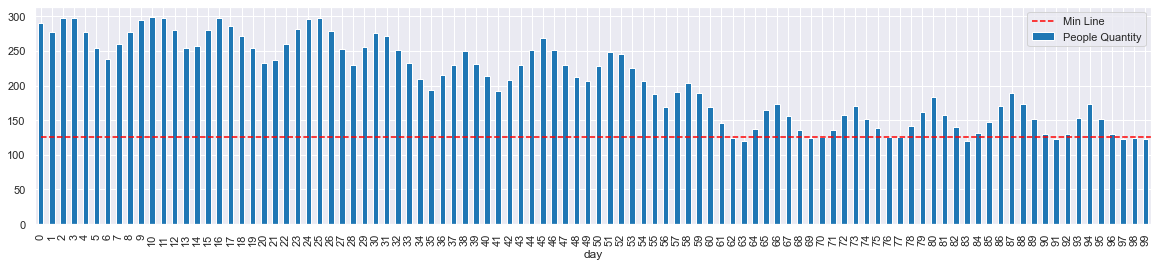

In [42]:
# 安排上的每日出现人数可视化
sns.set_context("notebook")
ax = assigned_daily_occupancy.plot(kind='bar', figsize=(20, 4), rot=90)
ax.plot([0, 100], [125, 125], '--', color='r', label='Min Line')
plt.legend(['Min Line', 'People Quantity'])
plt.show()

<BarContainer object of 100 artists>

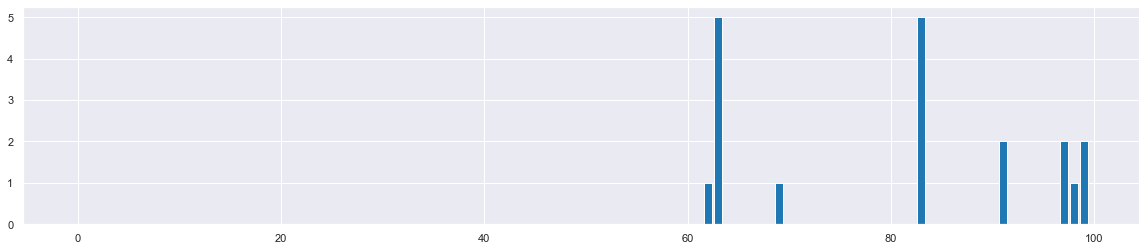

In [43]:
#  统计每一天剩余的最小承载量

min_occupancy = np.array(
    [max(0, MIN_OCCUPANCY - x) for x in assigned_daily_occupancy])
plt.figure(figsize=(20, 4))
plt.bar(range(100), height=min_occupancy)

In [44]:
min_occupancy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2])

Text(0, 100, 'Mean: 93')

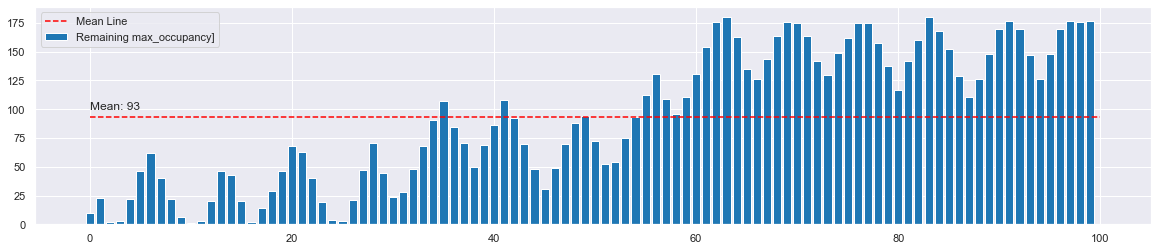

In [45]:
# 所有安排均没有超出最大承载量
max_occupancy = np.array([MAX_OCCUPANCY - x for x in assigned_daily_occupancy])
mean_occ = np.mean(max_occupancy)
plt.figure(figsize=(20, 4))
plt.bar(range(100), height=max_occupancy)
plt.plot([0, 100], [mean_occ] * 2, '--', color='r')
plt.legend(['Mean Line', 'Remaining max_occupancy]'])
plt.text(0, 100, 'Mean: %d' % mean_occ, fontsize=12)

In [46]:
max_occupancy

array([ 10,  23,   2,   3,  22,  46,  62,  40,  22,   6,   1,   3,  20,
        46,  43,  20,   2,  14,  29,  46,  68,  63,  40,  19,   4,   3,
        21,  47,  71,  45,  24,  28,  48,  68,  91, 107,  85,  71,  50,
        69,  86, 108,  92,  70,  48,  31,  49,  70,  88,  94,  72,  52,
        54,  75,  93, 112, 131, 109,  96, 111, 131, 154, 176, 180, 163,
       135, 126, 144, 164, 176, 175, 164, 142, 130, 149, 162, 175, 175,
       158, 138, 117, 142, 160, 180, 168, 152, 129, 111, 126, 148, 170,
       177, 170, 147, 126, 148, 170, 177, 176, 177])

In [47]:
# MIP规划

def solve_MIP(familes, min_occupancy, max_occupancy):
    # 创建求解器
    solver = Solver("AssignmentProblem", Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    n_family = len(familes)
    x = {}

    # 存储100天里每天的家庭id
    cadidates = [[] for x in range(N_DAYS)]

    # 69个待安排的家庭的family_id
    for i in familes:
        # 第 i 个家庭的对每个choice偏好的天j
        for j in DESIRED[i, :]:
            cadidates[j].append(i)
            # 定义布尔变量X[i,j]， i代表family_id, j代表偏好的天
            x[i, j] = solver.BoolVar(name='x[%i,%i]' % (i, j))

    # 每日参观人数
    daily_occupancy = [
        solver.Sum([x[i, j] * FAMILY_SIZE[i] for i in cadidates[j]])
        for j in range(N_DAYS)
    ]

    #  每个家庭在10个choice中出现总次数
    family_presence = [
        solver.Sum([x[i, j] for j in DESIRED[i, :]]) for i in familes
    ]

    # 设定目标函数preference_cost 部分
    temp = [
        pcost_mat[i, j] * x[i, j] for i in familes
        for j in DESIRED[i, :]
    ]
    preference_cost = solver.Sum(temp)

    # 设定求最小值
    solver.Minimize(preference_cost)

    # 设定约束条件
    # 每个家庭只出现一次
    for i in range(n_family):
        solver.Add(family_presence[i] == 1)

    # 每天访问人数约束: 在剩余最小承载量和剩余最大承载量之间
    for i in range(N_DAYS):
        solver.Add(daily_occupancy[i] >= min_occupancy[i])
        solver.Add(daily_occupancy[i] <= max_occupancy[i])
        
    res_code = solver.Solve()

    if res_code == Solver.OPTIMAL:
        print("目标函数最优值:", solver.Objective().Value())
        # 取变量为1的值
        result = [(i, j, x[i, j].solution_value()) for i in familes
                  for j in DESIRED[i, :] if x[i, j].solution_value() > 0]
        result_df = pd.DataFrame(result, columns=['family_id', 'day', 'is_appear'])
    else:
        print("没找到最优解")

    print('耗时：', solver.wall_time())
    print('统计单纯形迭代的次数: ', solver.iterations())
    return result_df

In [48]:
remain_result_df = solve_MIP(familes, min_occupancy, max_occupancy)

目标函数最优值: 1242.0
耗时： 68
统计单纯形迭代的次数:  0


In [49]:
remain_result_df

,family_id,day,is_appear
0,97,95,1.0
1,233,91,1.0
2,244,38,1.0
3,248,32,1.0
4,295,46,1.0
...,...,...,...
57,4869,59,1.0
58,4886,98,1.0
59,4918,58,1.0
60,4936,73,1.0


In [50]:
# 结果汇总

remain_result_df.loc[:, 'family_size'] = FAMILY_SIZE[
    remain_result_df.family_id].copy()

In [51]:
merge_result = assigned_df.append(remain_result_df)
merge_result = merge_result.sort_values('family_id').reset_index(drop=True)
merge_result

,family_id,day,is_appear,family_size
0,0,51,1.0,4
1,1,25,1.0,4
2,2,99,1.0,3
3,3,1,1.0,2
4,4,52,1.0,4
...,...,...,...,...
4995,4995,15,1.0,4
4996,4996,87,1.0,2
4997,4997,31,1.0,6
4998,4998,91,1.0,5


In [52]:
#  结果评估
#  Score = preference cost + accounting penalty

predictions = merge_result['day'].values.copy()

In [53]:
pcost_mat

array([[1440, 1440, 1440, ..., 1440, 1440, 1440],
       [1440, 1440, 1440, ..., 1440, 1440, 1440],
       [1205, 1205, 1205, ..., 1205, 1205,    0],
       ...,
       [1910, 1910,  616, ..., 1910, 1910, 1910],
       [ 390, 1675, 1675, ..., 1675, 1675, 1675],
       [1440, 1440, 1440, ..., 1440, 1440, 1440]])

In [54]:
# 根据安排情况，计算preference cost
@njit(fastmath=True)
def get_preference_cost(predictions):
    # 储存当天访问人数
    daily_occupancy = np.zeros(N_DAYS + 1, dtype=np.int64)
    penalty = 0
    for i, p in enumerate(predictions):
        # 计算家庭人数
        n_people = FAMILY_SIZE[i]
        # 第i个家庭，p天访问时间的pcost
        penalty += pcost_mat[i, p]
        # 统计当天人数
        daily_occupancy[p] += n_people
    return penalty, daily_occupancy


# 根据安排的情况统计accounting cost
@njit(fastmath=True)
def get_accounting_cost(daily_occupancy):
    accounting_cost = 0.
    num_out_of_range = 0.
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        # 前一天
        n_pl = daily_occupancy[day + 1]
        # 当天
        n = daily_occupancy[day]
        
        # 如果超过了承载范围，则设置out_of_range
        num_out_of_range += (n > MAX_OCCUPANCY) or (n < MIN_OCCUPANCY)
        
        # 计算accounting cost
        accounting_cost += acost_mat[n, n_pl]
    return accounting_cost, num_out_of_range

@njit(fastmath=True)
def cost_func(predictions):
    # 根据预测结果计算偏好成本和accounting_cost
    preference_cost, daily_occupancy = get_preference_cost(predictions)
    accounting_cost, num_out_of_range = get_accounting_cost(daily_occupancy)
    # 越界无穷大，代表不允许超过承载范围
    final_cost = preference_cost + accounting_cost + 9999999 * num_out_of_range
    
    return final_cost

In [55]:
preference_cost, daily_occupancy = get_preference_cost(predictions)

In [56]:
preference_cost

75233

In [57]:
accounting_cost, num_out_of_range = get_accounting_cost(daily_occupancy)
accounting_cost

3363.282933895302

In [58]:
# 最终成本
cost_func(merge_result['day'].values)

78596.2829338953

In [59]:
# 保存预测结果
def save_result(pred, filename):
    result = pd.DataFrame(range(N_FAMILY), columns=['family_id'])
    result['assigned_day'] = pred + 1
    result.to_csv(filename, index=False)
    print(f"save to file {filename}")
    return result

In [60]:
result = save_result(merge_result['day'], 'submission.csv')

save to file submission.csv


In [61]:
# 方案优化
#通过更换family_id的选择，查找更好的score
#每次更换后，都对方案进行评估，选择更小的score方案

In [62]:
fobs = np.argsort(FAMILY_SIZE)
fobs.min(), fobs.max()

(0, 4999)

In [63]:
# 从成员最少的家庭开始打擂
def find_better(pred):
    """打擂法探索更好的方案"""
    fobs = np.argsort(FAMILY_SIZE)
    score = cost_func(pred)
    original_score = np.inf 
    # 如果找不到更新则终止
    while score < original_score:
        original_score = score
        for family_id in fobs:
            # 10个choice中探索
            for pick in range(10):
                # 得到family_id在choice_pick的日期 new
                new = DESIRED[family_id, pick]
                # 安排的原日期
                old = pred[family_id]
                # old替换为new
                pred[family_id] = new
                # 重新计算分数
                new_score = cost_func(pred)
                if new_score < score:
                    score = new_score
                else:
                    pred[family_id] = old
        print(f'成本:{score}')
    print(f"最终score={score}")
    return pred

In [64]:
pred = merge_result['day'].values.copy()
new_pred = find_better(pred)

成本:75134.34022659628
成本:73982.31203705008
成本:73523.23228533549
成本:73243.97263973276
成本:73114.86384138808
成本:73030.00614795453
成本:73008.58961123612
成本:72976.7592792808
成本:72964.62984592363
成本:72964.62984592363
最终score=72964.62984592363


In [65]:
# 从成员最多的家庭开始打擂
def find_better(prediction):
    """打擂法探索更好的方案"""
    pred = prediction.copy()
    fobs = np.argsort(FAMILY_SIZE)[::-1]
    score = cost_func(pred)
    original_score = np.inf 
    # 如果找不到更新则终止
    while score < original_score:
        original_score = score
        for family_id in fobs:
            # 10个choice中探索
            for pick in range(10):
                # 得到family_id在choice_pick的日期 new
                new = DESIRED[family_id, pick]
                # 安排的原日期
                old = pred[family_id]
                # old替换为new
                pred[family_id] = new
                # 重新计算分数
                new_score = cost_func(pred)
                if new_score < score:
                    score = new_score
                else:
                    pred[family_id] = old
        print(f'成本:{score}')
    print(f"最后的score={score}")
    return pred

pred = predictions.copy()

new_pred = find_better(pred)

成本:74838.51702849907
成本:74435.99196793434
成本:74045.73868523882
成本:73901.44121214704
成本:73780.82000947774
成本:73722.32355063813
成本:73722.32355063813
最后的score=73722.32355063813
